# SCEIR model 
Model is by John S McCaskill, with autonomous caution feedback, adapted from the SEI2R model which was outlined in the infection_disease_modelling repository (part three)
https://github.com/hf2000510/infectious_disease_modelling by Henri Froese and described in the article https://towardsdatascience.com/building-an-interactive-dashboard-to-simulate-coronavirus-scenarios-in-python-ed23100e0046.

This notebook is an adaptation and extension of the notebook by Henri Froese : see license conditions there.
Completed Fri Jun 12 by John McCaskill


Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#!pip3 install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
#!pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Curve Fitting Example

We want to fit the following curve:

In [4]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

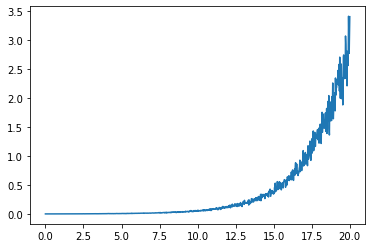

In [5]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [6]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [7]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [8]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

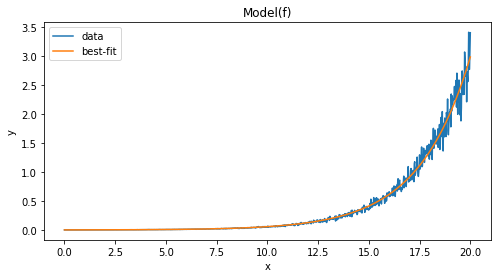

In [9]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [10]:
result

# Supplemental and Coronavirus Data

In [2]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

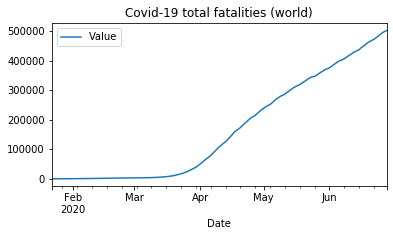

In [3]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [4]:
plt.gcf().subplots_adjust(bottom=0.15)  

def plotter(t, S, S_c, E, I, C, R, D, B, p1, p2, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,8))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, S_c, 'b--', alpha=0.7, linewidth=2, label='Susceptible cau')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, S_c, 'b--', alpha=0.7, linewidth=2, label='Susceptible cau')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SCEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        beds = [B(t1) for t1 in t]
        ax1.plot(t, beds, 'b--', alpha=0.7, linewidth=2, label='Beds')
    else:
        fmt = '%Y-%m-%d'
        xx = [mdates.date2num(dd)-mdates.date2num(x_ticks[0]) for dd in x_ticks ]
        beds = [B(td) for td in xx]
        ax1.plot(x_ticks, beds, 'b--', alpha=0.7, linewidth=2, label='Beds')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('Beds over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)   
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [5]:
def deriv(y, t, beta, gamma, sigma, c_0, c_1, c_2, c_3, N, p_I_to_C, p_C_to_D, Beds):
    S, S_c, E, I, C, R, D = y

    def caution(C,Beds,c_3):
        b = Beds(t)*c_3    # the transition to caution occurs at (c_3=0.1) 10% of ICU beds occupied with critical cases
        # b = Beds(0)*c_3  # in this case only the initial bed count for ICUs is used in caution
        return 1./(1.+np.exp(-5.*(C-b)/b))
    
    dSdt = -beta * I * S / N - c_2 * S * caution(C,Beds,c_3) + c_1 * S_c
    dScdt = -c_0 * beta * I * S_c / N + c_2 * S * caution(C,Beds,c_3) - c_1 * S_c
    dEdt = beta * I * (S + c_0 * S_c) / N - sigma * E
    dIdt = sigma * E - 1./12.0 * p_I_to_C * I - gamma * (1. - p_I_to_C) * I
    dCdt = 1./12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1. - p_C_to_D) * 1./6.5 * min(Beds(t), C)
    dRdt = gamma * (1. - p_I_to_C) * I + (1. - p_C_to_D) * 1./6.5 * min(Beds(t), C)
    dDdt = 1./7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dScdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [6]:
gamma = 1.0/9.0
sigma = 1.0/3.0
def Model(days, agegroups, beds_per_100k, beta,  c_0, c_1, c_2, c_3, prob_I_to_C, prob_C_to_D,
          s, gamma, sigma):
    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, c_0, c_1, c_2, c_3, N,
                                     prob_I_to_C, prob_C_to_D, Beds))
    S, S_c, E, I, C, R, D = ret.T
    return t, S, S_c, E, I, C, R, D, Beds, prob_I_to_C, prob_C_to_D

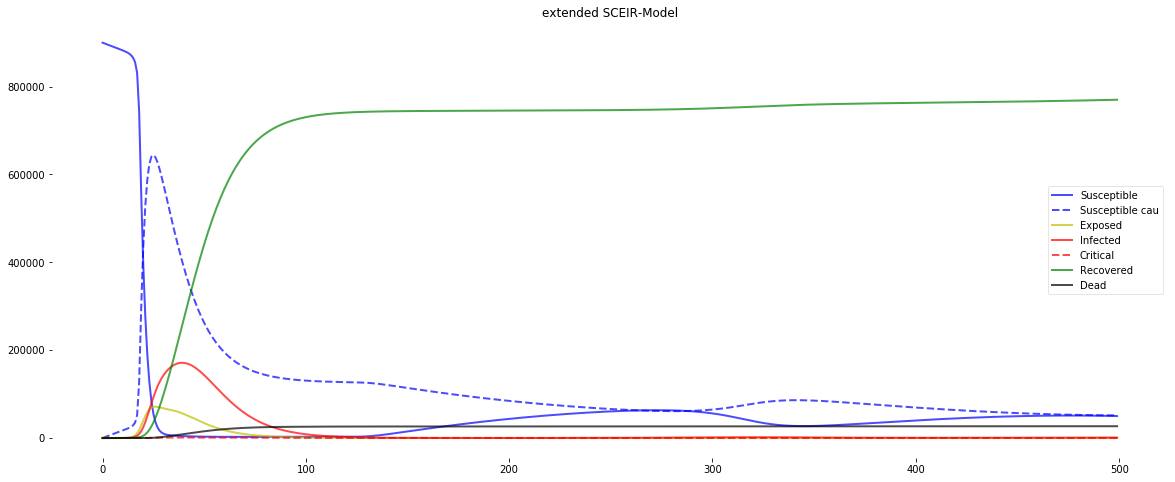

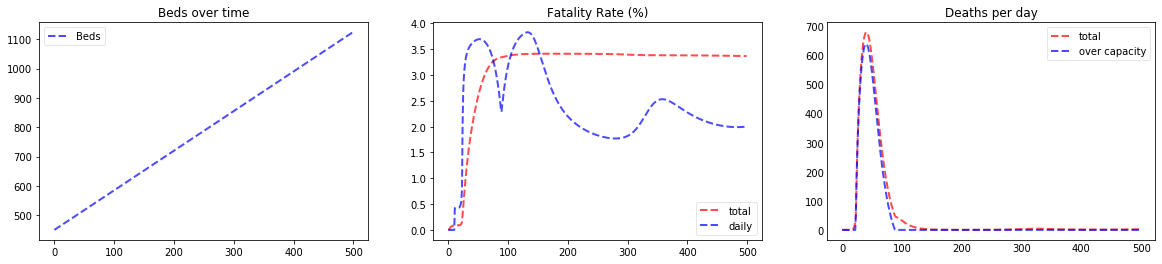

In [7]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, beta=2, 
               c_0=0.1, c_1=0.007, c_2=0.3, c_3=0.1,
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003, gamma=1.0/9.0, sigma=1.0/3.0))

# Fitting

In [8]:
# parameters
country="Japan"
data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
agegroups = agegroup_lookup[country]
beds_per_100k = beds_lookup[country]
outbreak_shift = 30
params_init_min_max = {"beta": (0.5, 0.2, 2.),
                       "c_0": (0.1, 0., 0.8), "c_1": (0.07, 0.03, 0.1),
                       "c_2": (0.1, 0.,10.), "c_3": (0.1,0.01,0.5),
                       "prob_I_to_C": (0.1, 0.01, 0.1), "prob_C_to_D": (0.5, 0.2, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value, vary?)}

In [9]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, c_0, c_1, c_2, c_3, beta, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, beta, c_0, c_1, c_2, c_3, prob_I_to_C, prob_C_to_D, s, gamma, sigma)
    return ret[7][x]

In [10]:
from IPython.display import HTML
from ipywidgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

def isolveplot(tmax, beta,c_0,c_1,c_2,c_3,p_I_to_C,p_C_to_D,s,gamma,sigma):
    
    #plotter(*Model(tmax, agegroup_lookup["Italy"], beds_lookup["Italy"], beta, c_0, c_1, c_2 ,p_I_to_C, p_C_to_D, s, gamma, sigma));
    plotter(*Model(tmax, [100000,100000,100000,100000,100000,100000,100000,1000000,1000000], 50., beta, c_0, c_1, c_2, c_3, p_I_to_C, p_C_to_D, s, gamma, sigma));

interact(isolveplot,
         tmax=IntSlider(min=0,max=500,step=1,value=500,description='tmax',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'), 
         beta=FloatSlider(min=0,max=4,step=0.01,value=2.0,description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),   
         c_0=FloatSlider(min=0,max=1,step=0.01,value=0.1,description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=0.007,description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=10,step=0.01,value=0.3,description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_3=FloatSlider(min=0,max=1,step=0.01,value=0.1,description='c_3',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         p_I_to_C=FloatSlider(min=0,max=1,step=0.01,value=0.05,description=' p_I_to_C',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         p_C_to_D=FloatSlider(min=0,max=1,step=0.01,value=0.6,description=' p_C_to_D',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         s=FloatSlider(min=0,max=0.01,step=0.0001,value=0.003,description='s',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
        gamma=FloatSlider(min=0,max=1,step=0.01,value=1.0/9.0,description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
        sigma=FloatSlider(min=0,max=1,step=0.01,value=1.0/3.0,description='sigma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))

interactive(children=(IntSlider(value=500, continuous_update=False, description='tmax', layout=Layout(width='9…

<function __main__.isolveplot(tmax, beta, c_0, c_1, c_2, c_3, p_I_to_C, p_C_to_D, s, gamma, sigma)>

In [11]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

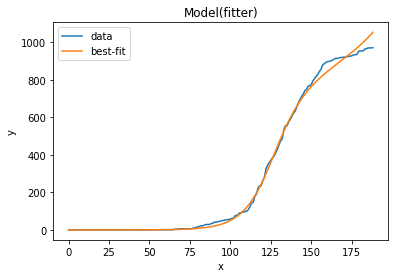

In [12]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

result.plot_fit(datafmt="-");

In [13]:
r = result.best_values
print(r)
results = [r['beta'],r['c_0'], r['c_1'], r['c_2'], r['c_3'],r['prob_I_to_C'], r['prob_C_to_D'], r['s'],gamma,sigma]
r

{'c_0': 8.491382497729261e-05, 'c_1': 0.030002376068158008, 'c_2': 1.315119948025981, 'c_3': 0.06525619957429205, 'beta': 0.32823065237955334, 'prob_I_to_C': 0.029867175326121632, 'prob_C_to_D': 0.32337573649651835, 's': 0.0010070621495585443}


{'c_0': 8.491382497729261e-05,
 'c_1': 0.030002376068158008,
 'c_2': 1.315119948025981,
 'c_3': 0.06525619957429205,
 'beta': 0.32823065237955334,
 'prob_I_to_C': 0.029867175326121632,
 'prob_C_to_D': 0.32337573649651835,
 's': 0.0010070621495585443}

Prediction for Italy


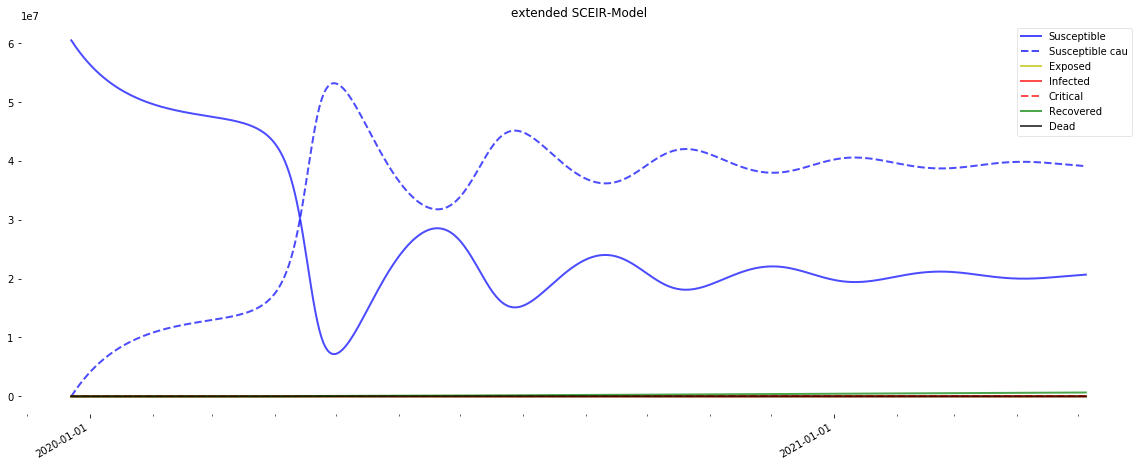

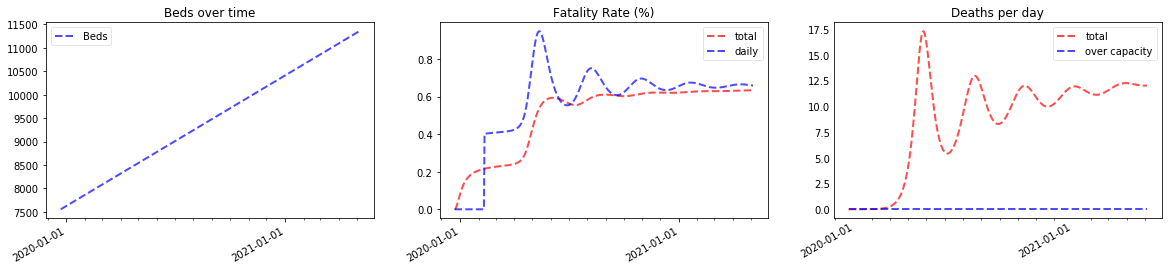

In [14]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")

plotter(*Model(full_days, agegroup_lookup["Italy"], beds_lookup["Italy"], *results), x_ticks=x_ticks);

In [15]:
beds_lookup["Italy"]

12.5

# fitting lots of countries

In [16]:

def fitter(x, c_0, c_1, c_2, c_3, beta, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, beta, c_0, c_1, c_2, c_3, prob_I_to_C, prob_C_to_D, s, gamma, sigma)
    return ret[7][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()


In [17]:
withBeds = set([x for x in beds_lookup])
withAgegroups = set([x for x in agegroup_lookup])
countries = withBeds.intersection(withAgegroups)
countries

{'Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Denmark',
 'Estonia',
 'Europe',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'India',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Russia',
 'Slovakia',
 'Slovenia',
 'South America',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'United Kingdom'}

In [18]:
len(countries)

39

In [19]:
# parameters
country='Australia'
data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
agegroups = agegroup_lookup[country]
beds_per_100k = beds_lookup[country]

In [20]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

fit_method = "leastsq"

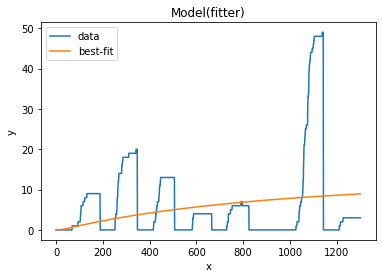

In [21]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-");

In [22]:
cshort = list(countries)[0:5]
cshort

['Netherlands', 'Chile', 'Portugal', 'Japan', 'Italy']

couldn't fit  Israel


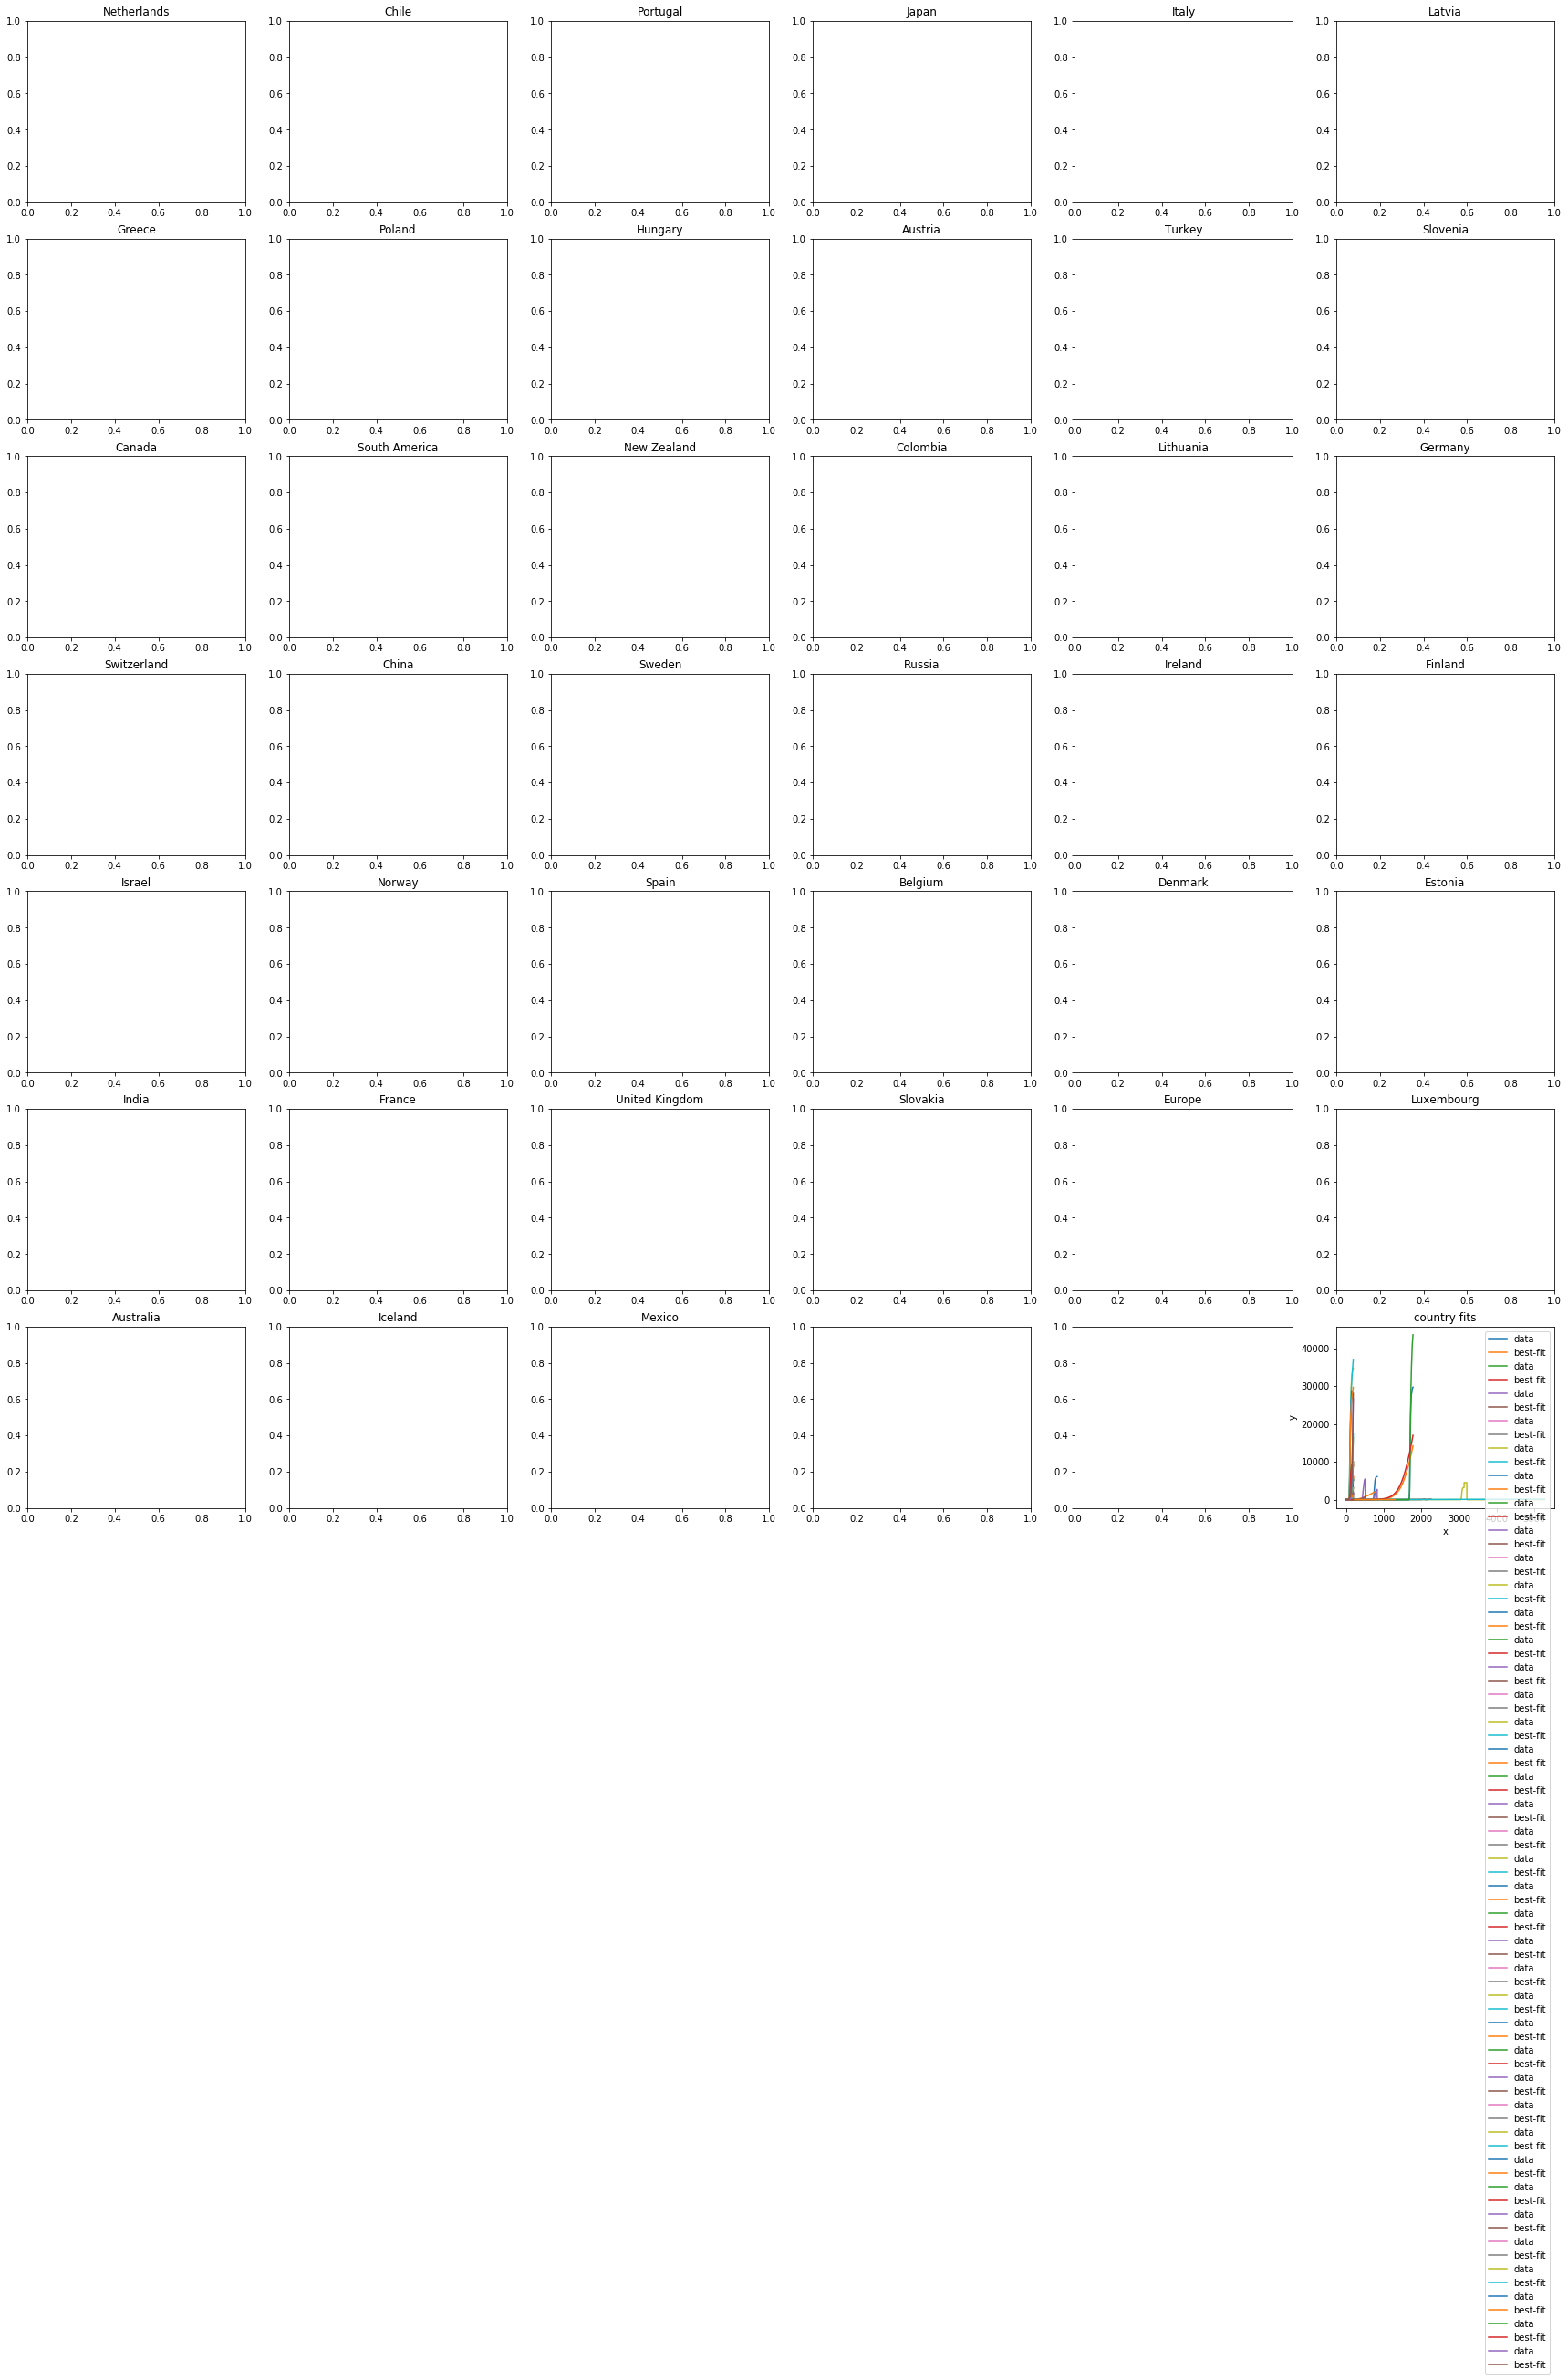

In [23]:
cshort = list(countries)
fits = {}
max_rows=7
max_cols=6
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,30))
idx = 0
for idx, country in enumerate(cshort):
    data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
    agegroups = agegroup_lookup[country]
    beds_per_100k = beds_lookup[country]

    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    row = idx // max_cols
    col = idx % max_cols
 #   axes[row, col].axis("off")
    try:
        result = mod.fit(y_data, params, method="least_squares", x=x_data)
        result.plot_fit(datafmt="-");
        fits[country]=result
        #axes[row,col].plot(y_data)
        axes[row, col].title.set_text(country)

    except:
        print("couldn't fit ",country)
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].title.set_text(country)
plt.title('country fits')
plt.show()     
for idx in range(len(countries),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
#    axes[row, col].axis("off")
        
#plt.subplots_adjust(wspace=.3, hspace=.2)
#plt.show()

In [ ]:
result

In [ ]:
fits[list(fits.keys())[0]].chisqr

In [ ]:
fitlist = [(idx,x,fits[x]) for idx,x in enumerate(fits)]

In [ ]:
fitlist[0][2].chisqr

In [ ]:
chisqr = [ff[2].chisqr for ff in fitlist]

In [ ]:
foo = [x for x in chisqr if x>1]
plt.hist(foo)


In [ ]:
plt.bar(list(range(len(foo))),foo,log=True)

In [ ]:
(np.log(min(foo)),np.log(max(foo)))


In [ ]:
idx = np.argsort(chisqr)

In [ ]:
foo = list(range(10))
foo[-3:][:2]

In [ ]:
[round(chisqr[i]) for i in  idx]

In [ ]:
idx[::-1][:5]

In [ ]:
for i in idx[::-1][:15]:
    ii,country,fit = fitlist[i]
    print(ii,country,'\t\t',chisqr[i])

## Plot fits after the fact

These have problems. :/

Probably because the Model stored in each fit depends on some global variables that are changed from one fit to the next...


In [ ]:
for i in idx[::-1][:10]:
    ii,country,fit = fitlist[i]
    print(ii,country)
    try:
        fit.plot_fit()
        plt.title(' '.join([country,str(round(chisqr[i]))]))
        plt.show()
    except:
        print("couldn't fit ",ii,country)

In [ ]:
fit = fits['Italy']
fit.plot_fit()